Keine gültigen Matchings gefunden!


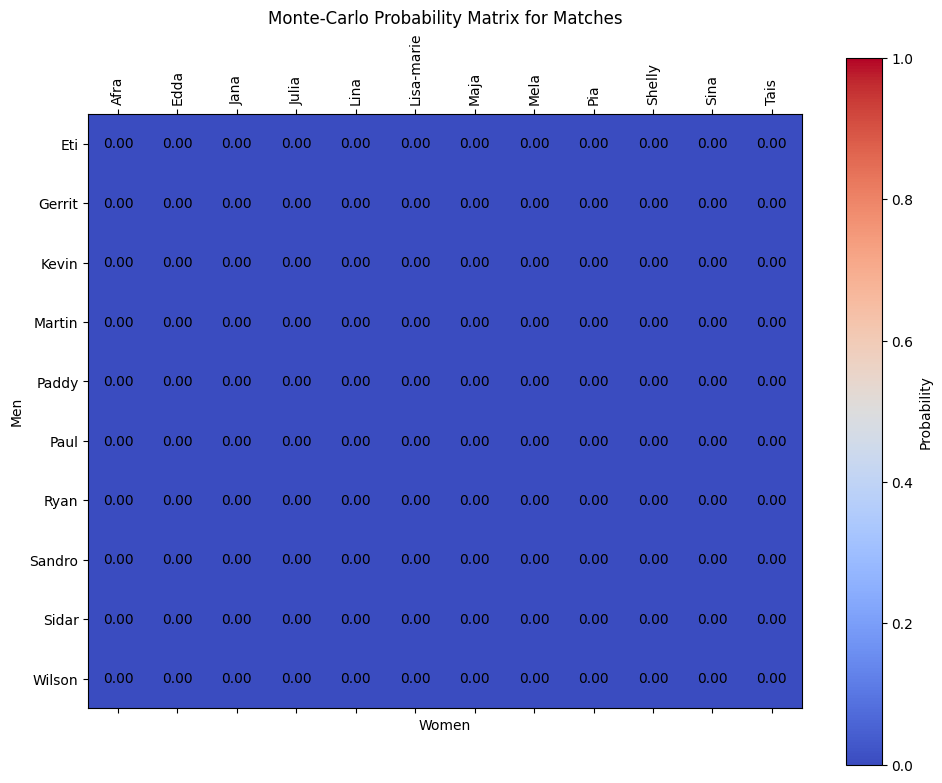

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
import random
from copy import deepcopy


def load_data(filename):
    """
    Load JSON data from the given file.
    """
    with open(filename, 'r') as f:
        return json.load(f)


def initialize_probabilities(participants):
    """
    Initialize a probabilities dictionary and a fixed dictionary for all man-woman pairs.
    - probabilities[(man, woman)] starts at 0.5
    - fixed[(man, woman)] starts as False
    """
    probabilities = {}
    fixed = {}
    men = [man.lower() for man in participants['men']]
    women = [woman.lower() for woman in participants['women']]
    for man in men:
        for woman in women:
            probabilities[(man, woman)] = 0.5
            fixed[(man, woman)] = False
    return probabilities, fixed


def update_truth_booths(probabilities, fixed, truth_booths):
    """
    Update probabilities and fixed values based on truth booth results:
    - If a pair is confirmed as a match, set probability to 1.0 and exclude that man or woman from any other pair.
    - If a pair is confirmed not a match, set its probability to 0.0.
    """
    for booth in truth_booths:
        man = booth['man'].lower()
        woman = booth['woman'].lower()
        pair = (man, woman)

        if booth['is_match']:
            # Confirm this pair
            probabilities[pair] = 1.0
            fixed[pair] = True
            # Exclude this man from any other pair
            for other_pair in list(probabilities.keys()):
                if other_pair[0] == man and other_pair != pair:
                    probabilities[other_pair] = 0.0
                    fixed[other_pair] = True
            # Exclude this woman from any other pair
            for other_pair in list(probabilities.keys()):
                if other_pair[1] == woman and other_pair != pair:
                    probabilities[other_pair] = 0.0
                    fixed[other_pair] = True
        else:
            # Confirm they are not a match
            probabilities[pair] = 0.0
            fixed[pair] = True

    return probabilities, fixed


def normalize_possible_pairs(probabilities, fixed, participants):
    """
    Normalize probabilities for each man to ensure that if no pair is fixed to 1.0 for that man,
    the sum of probabilities for the remaining potential partners is 1.0.
    """
    men = [m.lower() for m in participants['men']]
    women = [w.lower() for w in participants['women']]

    for man in men:
        # Check if there's already a fixed perfect match for this man
        has_fixed_match = any(
            fixed[(man, woman)] and probabilities[(man, woman)] == 1.0
            for woman in women
        )
        if has_fixed_match:
            continue

        # If not, spread probability evenly among all remaining possible women
        possible_women = [woman for woman in women if not fixed[(man, woman)]]
        if possible_women:
            new_prob = 1.0 / len(possible_women)
            for woman in possible_women:
                probabilities[(man, woman)] = new_prob

    return probabilities


def plot_probability_matrix(probabilities, participants, title="Probability Matrix for Matches"):
    """
    Plot a probability matrix (men vs. women) as a heatmap.
    """
    men = [m.lower() for m in participants['men']]
    women = [w.lower() for w in participants['women']]

    matrix = np.zeros((len(men), len(women)))

    for i, man in enumerate(men):
        for j, woman in enumerate(women):
            matrix[i, j] = probabilities.get((man, woman), 0)

    fig, ax = plt.subplots(figsize=(10, 8))
    cax = ax.matshow(matrix, cmap='coolwarm', vmin=0, vmax=1)

    plt.xticks(ticks=np.arange(len(women)), labels=[w.capitalize() for w in women], rotation=90)
    plt.yticks(ticks=np.arange(len(men)), labels=[m.capitalize() for m in men])

    for i in range(len(men)):
        for j in range(len(women)):
            ax.text(j, i, f"{matrix[i, j]:.2f}", ha='center', va='center', color='black')

    plt.colorbar(cax, label="Probability")
    plt.xlabel("Women")
    plt.ylabel("Men")
    plt.title(title)
    plt.tight_layout()
    plt.show()


def monte_carlo_simulation(data, probabilities, fixed, num_simulations=10000):
    """
    Führt eine Monte Carlo Simulation durch, indem in jeder Iteration ein vollständiges Matching (unter Beachtung der fixierten Paare)
    zufällig vervollständigt wird. Anschließend wird geprüft, ob das generierte Matching mit den Ergebnissen der Match Ceremonies
    (d.h. dem bereinigten Score) konsistent ist.
    
    Zur Überprüfung der Konsistenz wird für jede Matching Night (Match Ceremony) gezählt, wie viele der in der Ceremony
    gezeigten Paare im simulierten Matching vorkommen. Diese Zahl muss dem erwarteten Wert entsprechen:
       Erwartet = (Anzahl der Truth-Booth bestätigten Paare in der Ceremony) + (bereinigter Score der Ceremony)
    
    Es werden nur die Matchings gezählt, die alle Einschränkungen erfüllen. Auf Basis der gültigen Matchings
    wird dann für jedes Paar die relative Häufigkeit ermittelt.
    """
    participants = data['participants']
    men = [m.lower() for m in participants['men']]
    women = [w.lower() for w in participants['women']]
    
    # Forced matches und verbotene Paare extrahieren
    forced_matches = {}  # z.B. {"kevin": "amy"}
    forbidden_pairs = set()
    for pair, is_fixed in fixed.items():
        if is_fixed:
            if probabilities[pair] == 1.0:
                forced_matches[pair[0]] = pair[1]
            elif probabilities[pair] == 0.0:
                forbidden_pairs.add(pair)
    
    # Alle Match Ceremonies extrahieren: Für jede Ceremony speichern wir die Paare und den bereinigten Score
    ceremonies = []
    for episode in data['episodes']:
        if 'match_ceremony' in episode and episode['match_ceremony']:
            ceremony_pairs = set()
            for p in episode['match_ceremony']['pairs']:
                ceremony_pairs.add((p['man'].lower(), p['woman'].lower()))
            # Bereinigter Score entspricht den zusätzlichen korrekten Paaren (Truth-Booth-Paare wurden bereits berücksichtigt)
            ceremonies.append({
                'pairs': ceremony_pairs,
                'score': episode['match_ceremony']['score']
            })
    
    valid_matchings = 0
    pair_frequencies = { (m, w): 0 for m in men for w in women }
    
    # Bestimme die verbleibenden Männer und Frauen (die nicht durch Truth Booths festgelegt sind)
    remaining_men = [m for m in men if m not in forced_matches]
    forced_women = set(forced_matches.values())
    remaining_women = [w for w in women if w not in forced_women]
    
    # Monte Carlo Simulation
    for _ in range(num_simulations):
        # Zufälliges Matching für die verbleibenden Paare generieren
        shuffled_women = remaining_women.copy()
        random.shuffle(shuffled_women)
        candidate = deepcopy(forced_matches)  # Beginne mit den festgelegten (forced) Paaren
        
        # Weise jedem verbleibenden Mann eine zufällig ausgewählte Frau zu
        for i, m in enumerate(remaining_men):
            candidate[m] = shuffled_women[i]
        
        # Überprüfe, ob verbotene Paare (z.B. aus abgelehnten Truth Booths) vorkommen
        valid = True
        for m, w in candidate.items():
            if (m, w) in forbidden_pairs:
                valid = False
                break
        if not valid:
            continue
        
        # Überprüfe für jede Match Ceremony, ob das simulierte Matching zum bereinigten Score passt.
        for ceremony in ceremonies:
            ceremony_pairs = ceremony['pairs']
            # Zähle, wie viele Paare aus dem simulierten Matching in der Ceremony vorkommen
            count = sum(1 for m, w in candidate.items() if (m, w) in ceremony_pairs)
            # Bestimme, wie viele dieser Paare bereits durch Truth Booths (forced) festgelegt wurden
            forced_count = sum(1 for m, w in candidate.items() if (m, w) in ceremony_pairs and m in forced_matches)
            # Erwartet wird: forced_count + zusätzlicher korrekter Treffer (bereinigter Score)
            expected = forced_count + ceremony['score']
            if count != expected:
                valid = False
                break
        if not valid:
            continue
        
        # Wenn alle Bedingungen erfüllt sind, gilt das Matching als gültig
        valid_matchings += 1
        for m, w in candidate.items():
            pair_frequencies[(m, w)] += 1

    print(f"Valid matchings found: {valid_matchings} out of {num_simulations} simulations.")
    
    # Umrechnung der Häufigkeiten in relative Wahrscheinlichkeiten
    if valid_matchings > 0:
        for key in pair_frequencies:
            pair_frequencies[key] /= valid_matchings
            
    return pair_frequencies


def plot_pair_counts(pair_counts, participants, title="Monte Carlo Simulation: Paarwahrscheinlichkeiten"):
    """
    Plottet ein Balkendiagramm, das die Häufigkeit der in der Simulation gefundenen Paare zeigt.
    """
    pairs = list(pair_counts.keys())
    counts = [pair_counts[p] for p in pairs]
    labels = [f"{man.capitalize()} - {woman.capitalize()}" for man, woman in pairs]

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(labels, counts)
    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Paare")
    plt.ylabel("Relative Häufigkeit")
    plt.title(title)
    plt.tight_layout()
    plt.show()


def main():
    # Lade Daten
    data = load_data("Season_5.json")
    probabilities, fixed = initialize_probabilities(data['participants'])

    # 1. Truth Booth Ergebnisse verarbeiten
    for episode in data['episodes']:
        if 'truth_booths' in episode and episode['truth_booths']:
            probabilities, fixed = update_truth_booths(probabilities, fixed, episode['truth_booths'])

    # 2. Anpassung der Match Ceremonies basierend auf bestätigten Matches
    for episode in data['episodes']:
        if 'match_ceremony' in episode and episode['match_ceremony']:
            match_ceremony = episode['match_ceremony']
            episode_num = episode['number']
            confirmed_match_count = 0
            for p in match_ceremony['pairs']:
                key = (p['man'].lower(), p['woman'].lower())
                if fixed.get(key, False) and probabilities.get(key, 0) == 1.0:
                    confirmed_match_count += 1
            if confirmed_match_count > 0:
                print(f"Found confirmed perfect match in Match Ceremony {episode_num}")
                match_ceremony['score'] -= confirmed_match_count
                print(f"New Score: {match_ceremony['score']} in Match Ceremony {episode_num}")
                if match_ceremony['score'] == 0:
                    print(f"Blackout in Night {episode_num}")
                    for p in match_ceremony['pairs']:
                        key = (p['man'].lower(), p['woman'].lower())
                        if not (fixed.get(key, False) and probabilities.get(key, 0) == 1.0):
                            probabilities[key] = 0.0
                            fixed[key] = True

    # 3. Normalisiere die Wahrscheinlichkeiten
    probabilities = normalize_possible_pairs(probabilities, fixed, data['participants'])

    # 4. Plot der Wahrscheinlichkeitsmatrix (basierend auf bisherigen Ableitungen)
    plot_probability_matrix(probabilities, data['participants'], title="Wahrscheinlichkeitsmatrix vor Monte Carlo")

    # 5. Führe die Monte Carlo Simulation durch
    mc_pair_probabilities = monte_carlo_simulation(data, probabilities, fixed, num_simulations=10000)

    # 6. Plot der Monte Carlo Ergebnisse (Relative Häufigkeiten der Paare)
    plot_probability_matrix(mc_pair_probabilities, data['participants'], title="Monte Carlo Simulation: Paarwahrscheinlichkeiten")
    
    # Optional: Auch als Balkendiagramm plotten
    plot_pair_counts(mc_pair_probabilities, data['participants'])


if __name__ == "__main__":
    main()
